In [1]:
!pip install git+https://github.com/huggingface/transformers.git # Installs the transformers library from the Hugging Face GitHub repository.
!pip install pyttsx3 #Installs the pyttsx3 library, which is a text-to-speech conversion library in Python.
!pip install gTTS # Installs the gTTS (Google Text-to-Speech) library, which is used for text-to-speech conversion using Google's Text-to-Speech API.
!pip install pydub #Installs the pydub library, which provides a high-level interface for manipulating audio with Python.
!pip install playsound #Installs the playsound library, which is used to play audio files in a cross-platform way.
!pip install pyobject

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-14fz5dvt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-14fz5dvt
  Resolved https://github.com/huggingface/transformers.git to commit c712d05aa8fc8ba3ebe465079bd377d2dc9c2e07
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=9044569 sha256=e8435a65f1c5a17d02e2dbecfe01af68fb13aeb8bd4493787b51c2334898666d
  Stored in directory: /tmp/pip-ephem-wheel-cache-e54yzmcw/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
  Preparing metadata (setup.

In [2]:
import locale
# Get the preferred encoding
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
import requests #Allows you to send HTTP requests easily in Python.
import pyttsx3
from gtts import gTTS
from IPython.display import Audio #Allows displaying an audio widget in Jupyter/Colab notebooks.
from pydub import AudioSegment #Provides a high-level interface for manipulating audio with Python
from IPython.display import display, Javascript, HTML, Image #These are components of IPython.display used for displaying HTML, executing JavaScript, and displaying images in notebooks.
from google.colab.output import eval_js #Executes JavaScript code in a Google Colab environment.
from base64 import b64decode, b64encode #Provides functions for encoding and decoding data using Base64 encoding.
import cv2 #OpenCV (Open Source Computer Vision Library) is used for computer vision tasks.
import numpy as np
import PIL # PIL (or its fork Pillow) is used for opening, manipulating, and saving many different image file formats in Python.
import io
import html
import time
import os

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
def take_photo(folder='captured_photos', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Create buttons for capturing and stopping
            const captureBtn = document.createElement('button');
            captureBtn.textContent = 'Capture';
            const stopBtn = document.createElement('button');
            stopBtn.textContent = 'Stop';
            div.appendChild(captureBtn);
            div.appendChild(stopBtn);

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;

            let intervalId;

            // Capture images every 3 seconds
            captureBtn.onclick = () => {
                intervalId = setInterval(() => {
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    const data = canvas.toDataURL('image/jpeg', quality);
                    google.colab.kernel.invokeFunction('notebook.take_photo', [data], {});
                }, 3000);
            };

            // Stop capturing when the "Stop" button is clicked
            stopBtn.onclick = () => {
                clearInterval(intervalId);
                stream.getVideoTracks()[0].stop();
                div.remove();
            };
        }
        ''')

    display(js)
    eval_js('takePhoto({})'.format(quality))

In [6]:
folder = "captured_photos"
counter = 1  # Initialize counter

def save_photo(data, folder='captured_photos'):
    global counter  # Use global counter variable
    binary = b64decode(data.split(',')[1])
    if not os.path.exists(folder):
        os.makedirs(folder)
    filename = os.path.join(folder, 'photo_' + str(counter) + '.jpg')  # Unique filename with counter
    with open(filename, 'wb') as f:
        f.write(binary)
    print('Saved to {}'.format(filename))
    counter += 1  # Increment counter for the next photo

from google.colab import output
output.register_callback('notebook.take_photo', save_photo)

take_photo()

<IPython.core.display.Javascript object>

Saved to captured_photos/photo_1.jpg
Saved to captured_photos/photo_2.jpg
Saved to captured_photos/photo_3.jpg
Saved to captured_photos/photo_4.jpg
Saved to captured_photos/photo_5.jpg
Saved to captured_photos/photo_6.jpg


Available photos:
1. photo_1.jpg
2. photo_4.jpg
3. photo_3.jpg
4. photo_2.jpg
5. photo_6.jpg
6. photo_5.jpg
Enter the number corresponding to the photo you want to display: 1


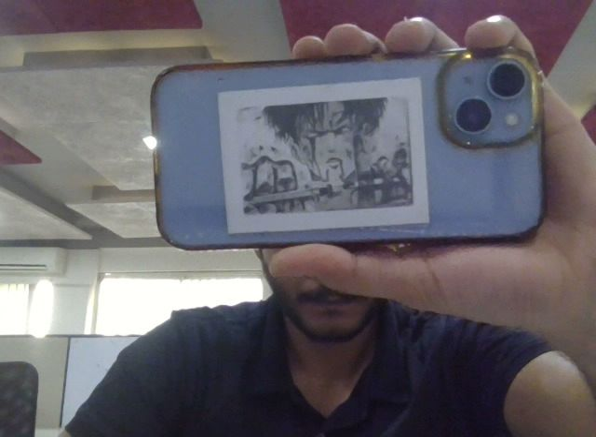

In [7]:
from PIL import Image
import os

folder_path = "captured_photos"
image_files = os.listdir(folder_path)

print("Available photos:")
for i, file_name in enumerate(image_files, start=1):
    print(f"{i}. {file_name}")

selection = input("Enter the number corresponding to the photo you want to display: ")
if selection.isdigit() and 1 <= int(selection) <= len(image_files):
    # Get the selected file name
    selected_file = image_files[int(selection) - 1]

    # Construct the full path to the selected image file
    file_path = os.path.join(folder_path, selected_file)

    image = Image.open(file_path).convert('RGB')
    image = image.resize((596, 437))

    # Display the image
    display(image)
else:
    print("Invalid selection.")

In [8]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load a pre-trained BLIP-2 model for conditional text generation
# Specify the model name ("Salesforce/blip2-opt-2.7b") and set the torch data type to float16
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [10]:
#caption generation
inputs = processor(image, return_tensors="pt").to(device, torch.float32)  # Specify float32 explicitly

generated_ids = model.generate(**inputs, max_length=50, min_length=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline = generated_text + "\n"

    output_file.write(text_with_newline)

    speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


a man holding up a cell phone with a picture of a painting on it in it's frame


In [11]:
prompt = "this is an image of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=60) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a man holding up his phone with a drawing on it in front of him in a room with a desk and a computer


In [12]:
prompt = "Question: What kind of image is the person trying to display? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=60) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


A photograph of a person in a black shirt and black pants, holding a cell phone with a picture of a person in a black shirt and black pants, holding a cell phone with a picture of a person in a black shirt and black pants, holding a cell phone with a picture of a person in


In [13]:
context = [
   ("What kind of image is the person playing ?", "He is showing the image of a something on this phone"),
   ("Where is he showing it?", "In his phone")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: What kind of image is the person playing ? Answer: He is showing the image of a something on this phone. Question: Where is he showing it? Answer: In his phone. Question: What for? Answer:


In [14]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=52, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


Both `max_new_tokens` (=52) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


To show it to others.
